In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35031 instead
  warnings.warn(


In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})

In [4]:
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})

In [5]:
ctrl = ctrl_sst.sst.compute()

In [6]:
OC = OC.sst.compute()

In [7]:
MC = MC.sst.compute()

In [8]:
VC = VC.sst.compute()

In [9]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df

In [10]:
ctrl = roll_longitude(ctrl)
MC = roll_longitude(MC)
VC = roll_longitude(VC)
OC = roll_longitude(OC)

In [11]:
ctrl = ctrl.sel(time = slice("0952-01-01", "1150-12-31"))
MC = MC.sel(time = slice("0952-01-01", "1100-12-31"))
OC = OC.sel(time = slice("0952-01-01", "1020-12-31"))
VC = VC.sel(time = slice("0952-01-01", "1020-12-31"))

In [12]:
len(OC)/12

69.0

In [13]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def dmi(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return  WTIO-SETIO

In [14]:
def percentiles_index(index, da1):
    #Step 0 get the index of the control. 
    da = index(ctrl)
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select years base don lenght of TS with replacement
        length = int(len(da1)/12)
        random_years = np.random.choice(da['time.year'], size=length, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    return percentiles-da.groupby("time.month").std("time")

In [15]:
OC_p = percentiles_index(dmi, OC)
MC_p = percentiles_index(dmi, MC)
VC_p = percentiles_index(dmi, VC)

In [16]:
OC_p

<xarray.DataArray 'sst' (quantile: 2, month: 12)>
array([[-0.05868005, -0.04148286, -0.03655108, -0.02892106, -0.02478675,
        -0.05293682, -0.05601331, -0.0687954 , -0.08115319, -0.07694119,
        -0.07068296, -0.075546  ],
       [ 0.05020765,  0.03415879,  0.03176389,  0.02218281,  0.02101399,
         0.04454928,  0.04400415,  0.05943181,  0.06977592,  0.06658031,
         0.05887976,  0.06269809]])
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantile  (quantile) float64 0.05 0.95

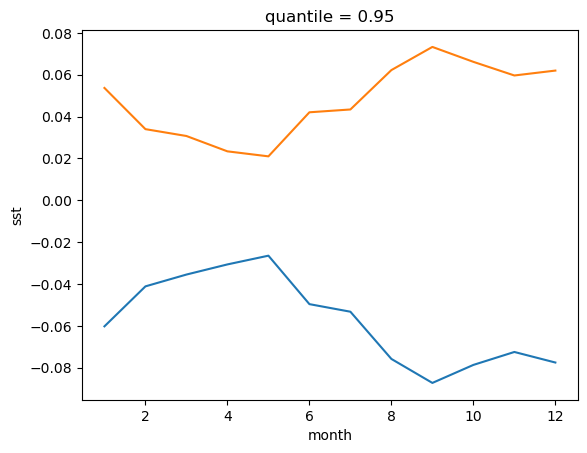

In [17]:
(VC_p)[0].plot()
(VC_p)[1].plot()

In [18]:
OC_dmi = dmi(OC).groupby("time.month").std("time")
MC_dmi = dmi(MC).groupby("time.month").std("time")
VC_dmi = dmi(VC).groupby("time.month").std("time")
ctrl_dmi = dmi(ctrl).groupby("time.month").std("time")

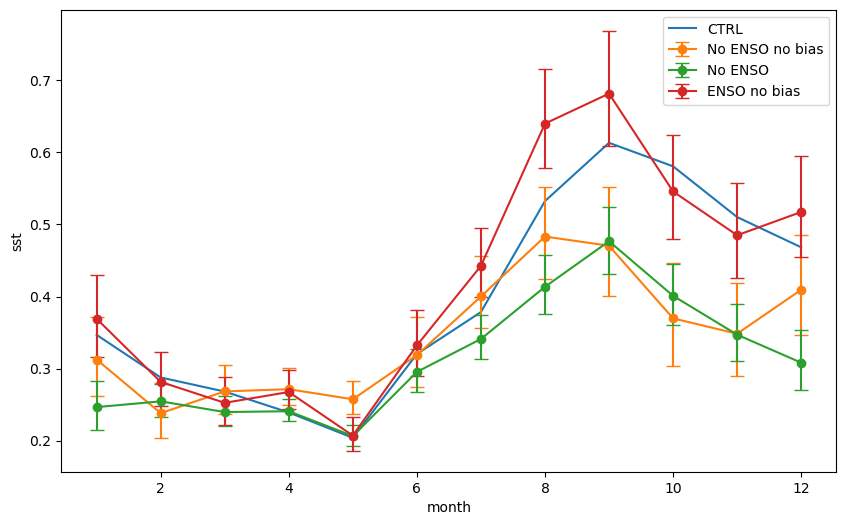

In [19]:
plt.figure(figsize = (10,6))
ctrl_dmi.plot(label = "CTRL")
plt.errorbar(OC_dmi.month, OC_dmi, yerr=[abs(OC_p[1]), abs(OC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO no bias')
plt.errorbar(MC_dmi.month, MC_dmi, yerr=[abs(MC_p[1]), abs(MC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO')
plt.errorbar(VC_dmi.month, VC_dmi, yerr=[abs(VC_p[1]), abs(VC_p[0])]
                 , fmt='-o', capsize=5, label = 'ENSO no bias')
plt.legend()

In [20]:
obs = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology2.nc", decode_times=False)

In [21]:
obs = obs.temp[0]

In [22]:
obs = obs.drop("DEPTH1_1")

In [23]:
obs = obs.rename({"TIME":"month", "GRID_Y_T":"yt_ocean", "GRID_X_T":"xt_ocean"})

In [24]:
obs["month"] = [1,2,3,4,5,6,7,8,9,10,11,12]

In [25]:
obs = roll_longitude(obs)

In [26]:
def plot_bias_sig_annual(ctrl, exp, temp_scale=2):
    ctrl_mn = ctrl.sel(month = slice(9,11)).mean('month')
    exp_mn = exp.groupby("time.season")["SON"].mean("time")
    # Now plot figure
    plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    # Set extent for longitude and latitude if provided
    ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())

    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='temp bias oC'))

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    #ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
    #            hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return


In [27]:
def plot_bias_sig_annual(ctrl, exp_list, temp_scale=2):
    ctrl_mn = ctrl.sel(month=slice(9, 11)).mean('month')
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # Position for colorbar
    
    for i, name in enumerate(exp_list.keys()):
        print(str(name))
        exp = exp_list[name]
        exp_mn = exp.groupby("time.season")["SON"].mean("time")
        bias = (exp_mn - ctrl_mn)
        
        ax = axs.flat[i]
        ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
        im = bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                                transform=ccrs.PlateCarree(), add_colorbar=False)
        ax.set_title(name+"-HadISST observations SON")
        ax.coastlines(color='k')
        ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
        ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
        ax.gridlines()
    
    fig.colorbar(im, cax=cbar_ax, label='temp bias oC')
    
    for ax in axs.flat:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    plt.tight_layout()
    plt.show()

In [28]:
exps1 = {"CTRL":ctrl, "ENSO no bias": VC, "No ENSO":MC, "No ENSO no bias":OC}

CTRL
ENSO no bias
No ENSO
No ENSO no bias


/jobfs/110151805.gadi-pbs/ipykernel_1753461/1196722266.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


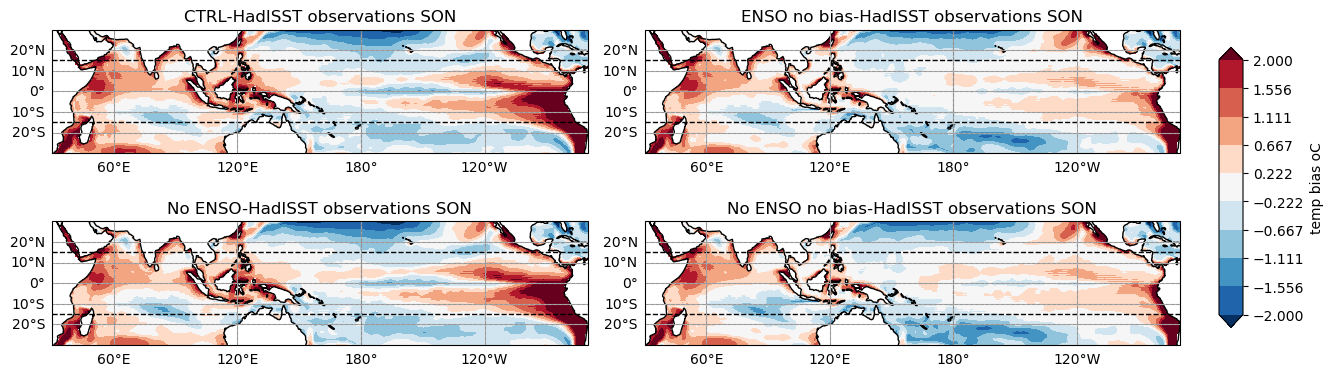

In [29]:
plot_bias_sig_annual(obs, exps1)


In [30]:
#PIOD-like mean state bias

In [62]:
def IOD_LIKE_bias(da, obs):
    da1 = da.groupby("time.month").mean("time") - obs
    W = da1.sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])
    E = da1.sel(xt_ocean=slice(90,110), yt_ocean=slice(-10,0)).mean(['xt_ocean', 'yt_ocean'])
    D = W-E
    return D

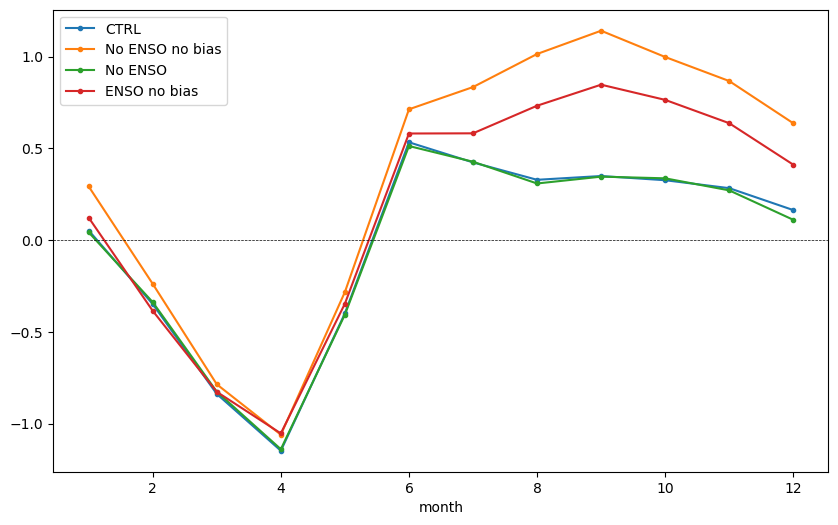

In [64]:
plt.figure(figsize = (10,6))
IOD_LIKE_bias(ctrl, obs).plot(marker='.', label = "CTRL")
IOD_LIKE_bias(OC, obs).plot(marker='.', label = "No ENSO no bias")
IOD_LIKE_bias(MC, obs).plot(marker='.', label = "No ENSO")
IOD_LIKE_bias(VC, obs).plot(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

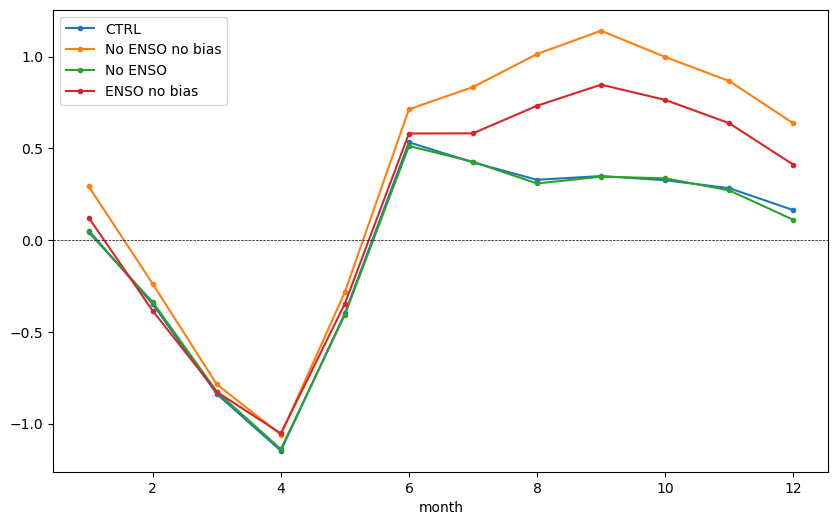

In [54]:
plt.figure(figsize = (10,6))
IOD_LIKE_bias(ctrl, obs).groupby("time.month").mean("time").plot(marker='.', label = "CTRL")
IOD_LIKE_bias(OC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO no bias")
IOD_LIKE_bias(MC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO")
IOD_LIKE_bias(VC, obs).groupby("time.month").mean("time").plot(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

In [61]:
print(IOD_LIKE_bias(ctrl, obs).mean("time").values)
print(IOD_LIKE_bias(OC, obs).mean("time").values)
print(IOD_LIKE_bias(MC, obs).mean("time").values)
print(IOD_LIKE_bias(VC, obs).mean("time").values)

-0.02252169595872034
0.3444339111492551
-0.029253124546519082
0.17241959200275403


In [58]:
plt.figure(figsize = (10,6))
IOD_LIKE_bias(ctrl, obs).mean("time").plot.scatter(marker='.', label = "CTRL")
IOD_LIKE_bias(OC, obs).mean("time").plot.scatter(marker='.', label = "No ENSO no bias")
IOD_LIKE_bias(MC, obs).mean("time").plot.scatter(marker='.', label = "No ENSO")
IOD_LIKE_bias(VC, obs).mean("time").plot.scatter(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

TypeError: No numeric data to plot.

<Figure size 1000x600 with 0 Axes>

In [35]:
#calculate the SST bias int he DMI boxes to create "mean state DMI bias plot"
test = ctrl.groupby("time.month") - obs

In [39]:
W = test.sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])

In [44]:
E = test.sel(xt_ocean=slice(90,110), yt_ocean=slice(-10,0)).mean(['xt_ocean', 'yt_ocean'])

In [45]:
D = W-E

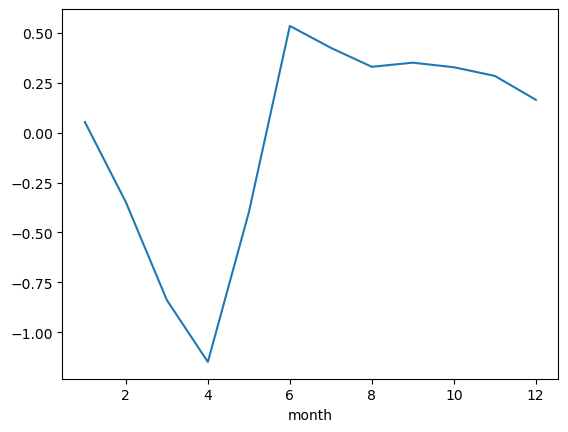

In [46]:
D.groupby("time.month").mean("time").plot()

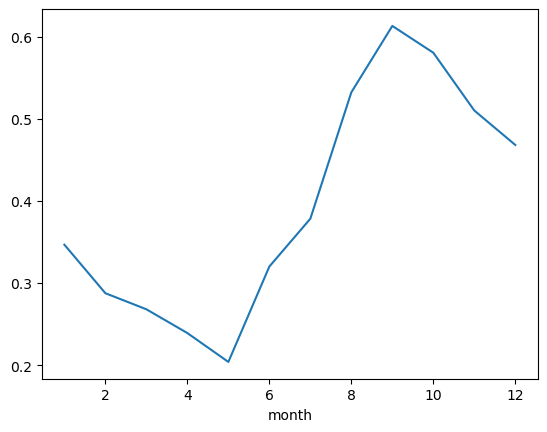

In [47]:
D.groupby("time.month").std("time").plot()

In [42]:
W2 = test.groupby("time.month").mean("time").sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])

In [65]:
def plot_std_dev_SON(ctrl, exp_list, temp_scale=1):
    ctrl_mn = ctrl.groupby("time.season")["SON"].std("time")
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    #cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # Position for colorbar
    
    for i, name in enumerate(exp_list.keys()):
        print(str(name))
        exp = exp_list[name]
        exp_mn = exp.groupby("time.season")["SON"].std("time")
        if i == 0:
            bias = ctrl_mn
            ax = axs.flat[i]
            ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
            im = bias.plot.contourf(ax=ax,  cmap="jet", vmax = 3, levels=10, extend='neither',
                                    transform=ccrs.PlateCarree(), add_colorbar=True)
            #ax.set_title(name+"-HadISST observations SON")
            ax.coastlines(color='k')
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
            ax.gridlines()
        else:
            bias = (exp_mn - ctrl_mn)
            ax = axs.flat[i]
            ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
            im = bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                                    transform=ccrs.PlateCarree(), add_colorbar=True)
            #ax.set_title(name+"-HadISST observations SON")
            ax.coastlines(color='k')
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
            ax.gridlines()

    
    for ax in axs.flat:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    plt.tight_layout()
    plt.show()

CTRL
ENSO no bias
No ENSO
No ENSO no bias


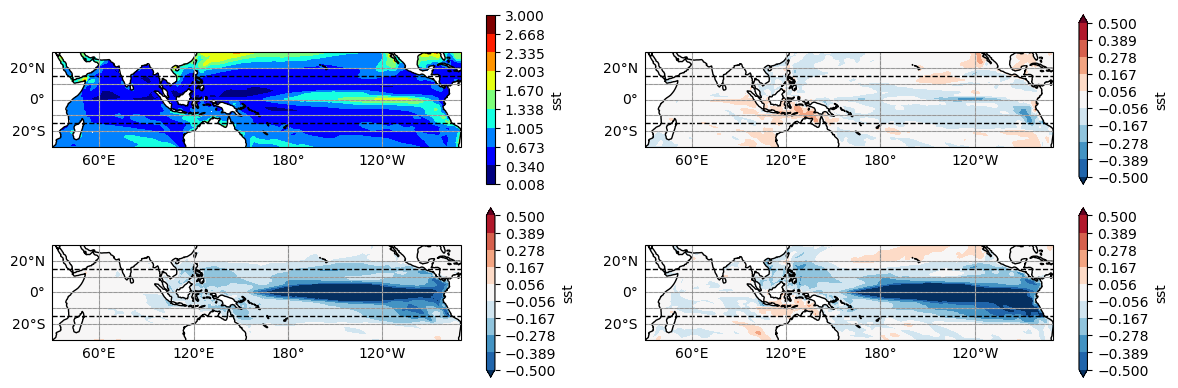

In [67]:
plot_std_dev_SON(ctrl, exps1, 0.5)

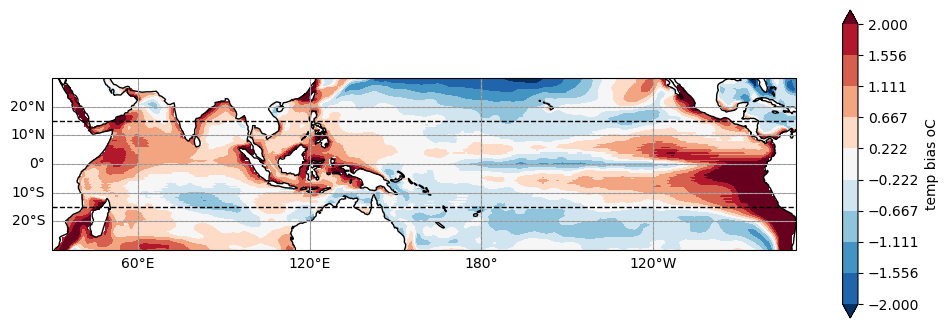

In [100]:
plot_bias_sig_annual(obs, ctrl)

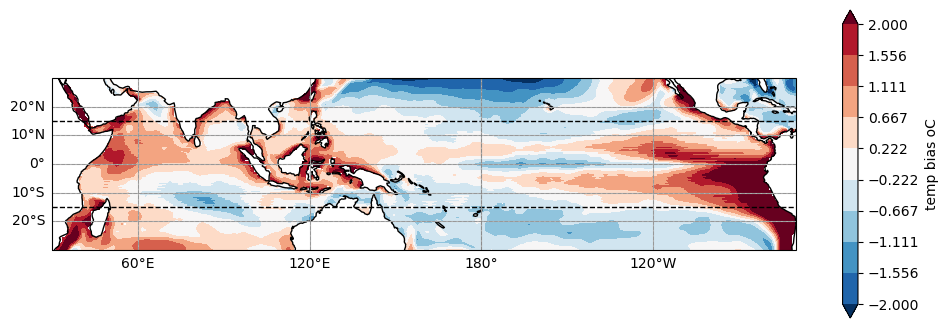

In [101]:
plot_bias_sig_annual(obs, MC)

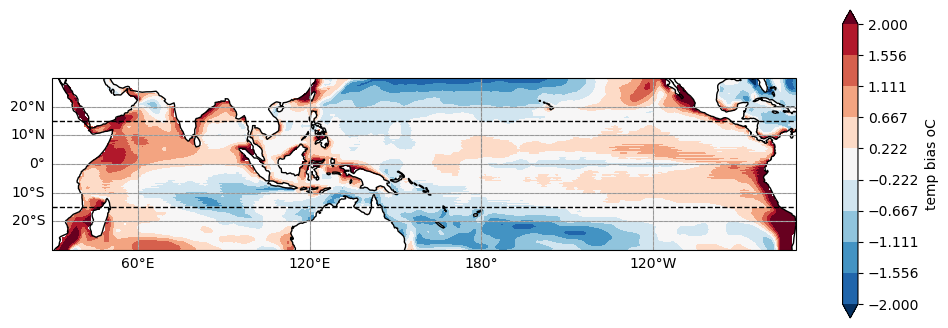

In [102]:
plot_bias_sig_annual(obs, OC)

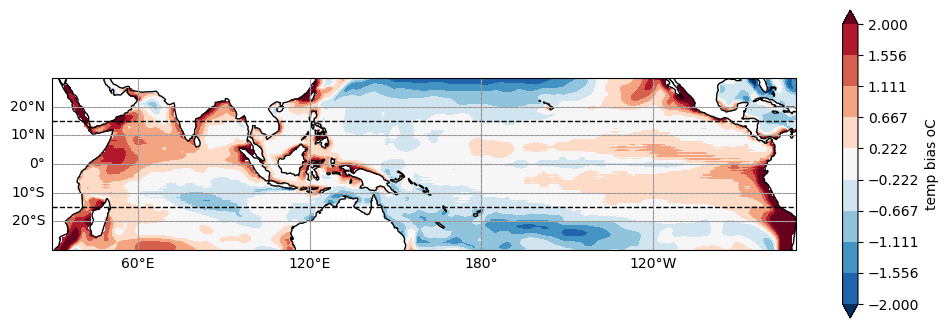

In [103]:
plot_bias_sig_annual(obs, VC)